## Week 6 Homework

---

### Q1: Let's start having some *real* fun...

We previously considered the normal-gamma specification 

$$\scriptsize
\begin{align*}
p(\theta,\tau|x) &\propto{} p(\theta,\tau,x) = p(x|\theta)p(\theta)p(\tau) \quad (\theta \perp\!\!\perp \tau) \leftarrow \text{independent priors} & p(\theta|x,\theta_0,\tau_0, \tau) &={} \text{N}\left(\frac{\left(\tau_0 \theta_0+\tau\sum_{i=1}^{n}x_{i}\right)}{(\tau_0+n\tau)}, \sigma^{-2}=\tau_0+n\tau \right)\\
&={}  \left[\prod_{i=1}^n\sqrt{\frac{\tau}{2\pi}} e^{-\frac{\tau\left(x_i-\theta\right)^2}{2}}\right] \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0\left(\theta-\theta_0\right)^2}{2}} \frac{\beta ^{\alpha}}{\Gamma(\alpha)} \tau^{\alpha -1}e^{-\beta \tau} & p(\tau|x, \alpha, \beta, \theta) &={} \text{Gamma}\left(\frac{\alpha}{2}+\frac{n}{2}, \frac{\beta}{2}+\frac{1}{2}\sum_{i=1}^n\left(x_i-\theta\right)^2 \right)\\{}\\
\end{align*}$$

How about instead we consider a "[location-scale-t](https://en.wikipedia.org/wiki/Student%27s_t-distribution#Location-scale_t-distribution)-norm-halfnorm-discrete-uniform" specification?

$$\large
\overset{x_i\; \sim\; \text{location-scale-t}(\mu, \sigma^2, \nu)}{\quad\quad\quad p(x|\mu,\sigma^2, \nu)} = {\prod_{i=1}^n
\frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right) \sqrt{\pi \nu \sigma^2}}\left(1+\frac{1}{\nu} \frac{(x_i-\mu)^2}{\sigma^2}\right)^{-(\nu+1) / 2}}$$

$$\scriptsize 
\begin{align}
p(\mu | \mu_0, \tau_0) &={} \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0}{2}\left(\mu-\mu_0\right)^2} & p(\sigma^2 | \sigma_0^2) &={} \sqrt{\frac{2}{\pi\sigma_0^2}} \exp \left(-\frac{(\sigma^2)^2}{2 \sigma_0^2}\right) 1_{[0,\infty]}(\sigma^2) & p(\nu=i) &={} \Bigg\{ \begin{array}{cl} \frac{1}{100} & \text{for }i=1,\cdots,100\\ 0 & \text{otherwise} \end{array}\\
& \textrm{normal} && \textrm{half-normal} && \textrm{discrete uniform}
\end{align}
$$

Um yeah we're gonna need a Metroposlis cleanup on aisles one two and three  
(or a slice or adapative squeeze rejection sampling steps... in place of Metroposlis steps)

*Implement the a Metroposlis within Gibbs algorithm to smaple from the posterior of the above specification. Use a "smallish" sample size, say $n=100$ and implement your acceptance probability on a log-scale as described in [piazza post @65_f1](https://piazza.com/class/m5jvyco84083fm/post/65_f1)*



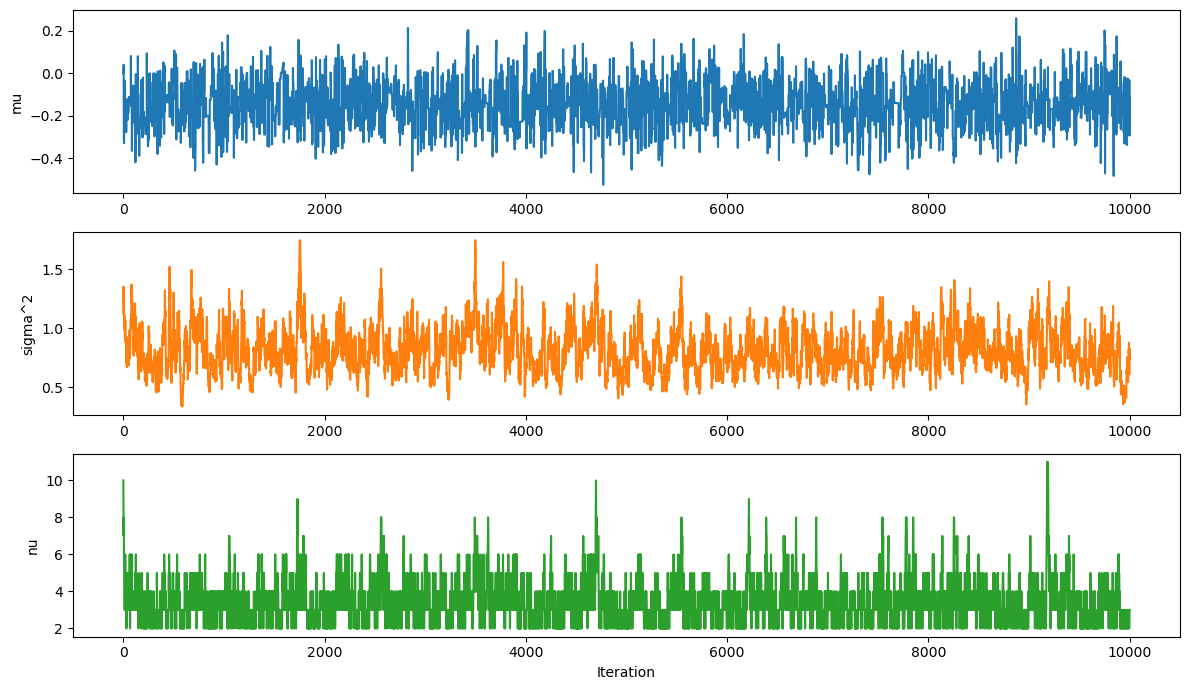

In [9]:
#Q1

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.special import gammaln

np.random.seed(42)

n = 100  # Number of data points

true_mu = 0.0  # True mean
true_sigma2 = 1.0  # True variance
true_nu = 5  # Degrees of freedom for the t-distribution

x = true_mu + np.sqrt(true_sigma2) * stats.t.rvs(df=true_nu, size=n)

mu0 = 0.0  # Prior mean for mu
tau0 = 1.0  # Precision parameter for mu
sigma0 = 1.0  # Scale parameter for sigma^2

# Log posterior function
def log_post(mu, sigma2, nu, x, mu0, tau0, sigma0):
    if sigma2 <= 0 or nu < 1 or nu > 100:
        return -np.inf
    
    # Log-likelihood (Student's t-distribution)
    Log_likelihood = np.sum(
        gammaln((nu + 1) / 2) - gammaln(nu / 2) - 0.5 * np.log(np.pi * nu * sigma2) -
        ((nu + 1) / 2) * np.log(1 + ((x - mu) ** 2) / (nu * sigma2))
    )
    
    # Log-priors for mu, sigma^2, and nu
    Log_priors_mu = 0.5 * np.log(tau0 / (2 * np.pi)) - (tau0 / 2) * (mu - mu0) ** 2
    Log_priors_sigma2 = 0.5 * np.log(2 / (np.pi * sigma0 ** 2)) - (sigma2 ** 2) / (2 * sigma0 ** 2)
    Log_priors_nu = -np.log(100)  # Uniform prior for nu over [1,100]

    return Log_likelihood + Log_priors_mu  + Log_priors_sigma2 + Log_priors_nu

# Number of iterations for the MCMC sampling
iters = 10000

mu_samples = np.zeros(iters)
sigma2_samples = np.zeros(iters)
nu_samples = np.zeros(iters, dtype=int)

# Initialize values for the parameters
mu_current = 0.0
sigma2_current = 1.0
nu_current = 10  # Initial degrees of freedom
log_post_current = log_post(mu_current, sigma2_current, nu_current, x, mu0, tau0, sigma0)

mu_prop_sd = 0.5  # Standard deviation for proposing new mu
log_sigma2_prop_sd = 0.1  # Standard deviation for proposing log(sigma^2)

# Metropolis-Hastings MCMC sampling
for t in range(iters):
    #1 mu
    mu_proposal = mu_current + np.random.normal(0, mu_prop_sd)
    log_post_proposal = log_post(mu_proposal, sigma2_current, nu_current, x, mu0, tau0, sigma0)
    if np.log(np.random.rand()) < log_post_proposal - log_post_current:
        mu_current = mu_proposal
        log_post_current = log_post_proposal
    mu_samples[t] = mu_current
    
    #2 sigma^2
    log_sigma2_current = np.log(sigma2_current)
    log_sigma2_proposal = log_sigma2_current + np.random.normal(0, log_sigma2_prop_sd)
    sigma2_proposal = np.exp(log_sigma2_proposal)  # Convert back to original scale
    log_post_proposal = log_post(mu_current, sigma2_proposal, nu_current, x, mu0, tau0, sigma0)
    if np.log(np.random.rand()) < log_post_proposal - log_post_current + log_sigma2_proposal - log_sigma2_current:
        sigma2_current = sigma2_proposal
        log_post_current = log_post_proposal
    sigma2_samples[t] = sigma2_current

    #3 nu
    nu_proposal = nu_current + np.random.choice([-1, 1])  # Propose nu by adding or subtracting 1
    if nu_proposal < 1:
        nu_proposal = 1
    if nu_proposal > 100:
        nu_proposal = 100
    log_post_proposal = log_post(mu_current, sigma2_current, nu_proposal, x, mu0, tau0, sigma0)

    # Accept/reject step for nu
    if np.log(np.random.rand()) < log_post_proposal - log_post_current:
        nu_current = nu_proposal
        log_post_current = log_post_proposal
    nu_samples[t] = nu_current

# Plot
plt.figure(figsize=(12, 7))

plt.subplot(3, 1, 1)
plt.plot(mu_samples, color='tab:blue')
plt.ylabel("mu")

plt.subplot(3, 1, 2)
plt.plot(sigma2_samples, color='tab:orange')
plt.ylabel("sigma^2")

plt.subplot(3, 1, 3)
plt.plot(nu_samples, color='tab:green')
plt.ylabel("nu")
plt.xlabel("Iteration")

plt.tight_layout()
plt.show()



### Q2: explore the role of sample size in providing inference for the degrees of freedom parameter $\nu$

*Implement the specification above using `PyMC` where you can explore inference on $\nu$ at different sample sizes. Provide a summarization and explanation of your findings.*

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, sigma, nu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, sigma, nu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, sigma, nu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu, sigma, nu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


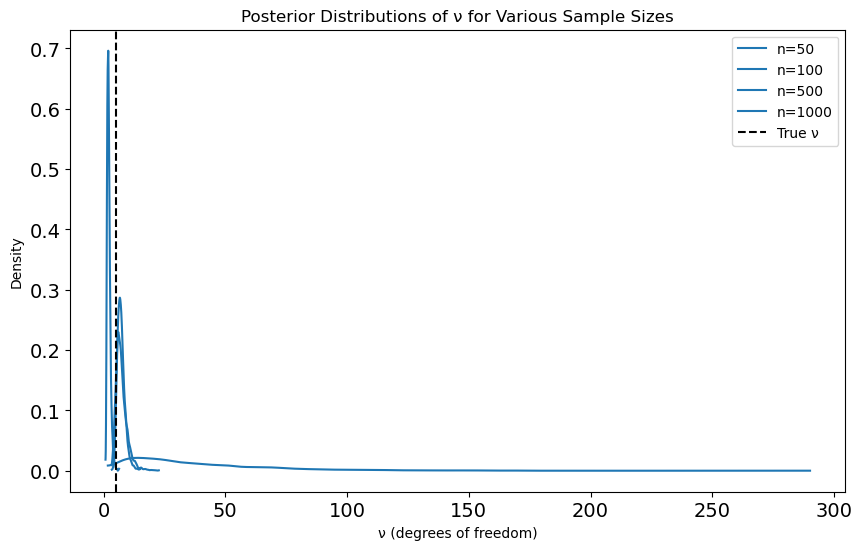

Results for Sample Size: 50
      mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  38.741  31.679   2.166   95.715      0.573    0.405    2221.0    2058.0   

    r_hat  
nu    1.0  
Results for Sample Size: 100
     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  2.108  0.678   1.061    3.366      0.015    0.011    1825.0    2164.0   

    r_hat  
nu    1.0  
Results for Sample Size: 500
     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  7.355  2.376   3.723   11.503       0.05    0.036    2294.0    2323.0   

    r_hat  
nu    1.0  
Results for Sample Size: 1000
     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  7.209  1.571   4.634   10.169      0.034    0.024    2244.0    2459.0   

    r_hat  
nu    1.0  


In [10]:
# Q2

import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy.stats import t

np.random.seed(42)

# Define sample sizes for experimentation
sample_sizes = [50, 100, 500, 1000]

# True distribution parameters
true_mu = 0.0
true_sigma = 1.0
true_nu = 5

# Dictionary to store inference results
posterior_results = {}

# Iterate through different sample sizes
for n in sample_sizes:
    # Generate synthetic data from a Student's t-distribution
    data = true_mu + true_sigma * t.rvs(df=true_nu, size=n)

    with pm.Model() as bayesian_model:
        # Define priors
        mu = pm.Normal("mu", mu=0, sigma=5)
        sigma = pm.HalfNormal("sigma", sigma=1)
        nu = pm.Exponential("nu", lam=1/30)  # Prior for degrees of freedom

        # Likelihood function
        observed_data = pm.StudentT("obs", nu=nu, mu=mu, sigma=sigma, observed=data)

        # Perform Bayesian sampling using NUTS
        trace = pm.sample(
            draws=2000, tune=1000, chains=2, 
            target_accept=0.9, return_inferencedata=True
        )

    # Store inference results
    posterior_results[n] = trace

# Plot posterior distributions of ν across different sample sizes
plt.figure(figsize=(10, 6))
for n in sample_sizes:
    az.plot_kde(posterior_results[n].posterior["nu"].values.flatten(), label=f"n={n}")

plt.axvline(true_nu, color="black", linestyle="--", label="True ν")
plt.xlabel("ν (degrees of freedom)")
plt.ylabel("Density")
plt.legend()
plt.title("Posterior Distributions of ν for Various Sample Sizes")
plt.show()

# Display result
for n in sample_sizes:
    print(f"Results for Sample Size: {n}")
    print(az.summary(posterior_results[n], var_names=["nu"]))


### Q3: the posterior predictive distribution does something like the following...

Let $p(\tau_i)$ be $\require{cancel} \textrm{gamma}\big(\tau_i | \alpha = \frac{\nu}{2}, \overset{\textrm{rate}\xcancel{\textrm{scale}}}{\beta = \frac{\nu}{2}}\big)$ and let $p(y_i|\tau_i)$ be $\textrm{N}(y_i | 0,\tau_i)$ and now integrate out the uncertainty in $\tau_i$ and see what distribution is left over for $y_i$.

*Go look at the gamma distribution and remember that you know that the integrals of unnormalized densities are the inverse of their normalizing constants. Then go look at the t distribution and determine what distribution the following expression defines. Then explain why the behavior demonstrated here is analagous to that of the posterior predictive distribution.*

$$\int p(y_i|\tau_i) p(\tau_i)  d\tau_i = \int \sqrt{\frac{\tau_i}{2\pi}}e^{-\frac{1}{2}\tau_i y_i^2} \frac {\frac{\nu}{2}^{\frac{\nu}{2}}}{\Gamma \left(\frac{\nu}{2}\right)} \tau_i^{\frac{\nu}{2}-1}e^{-\frac{\nu}{2}\tau_i} d\tau_i$$



## Q3 

$$
\int_0^{\infty} p\left(y_i \mid \tau_i\right) p\left(\tau_i\right) d \tau_i=\int_0^{\infty} \sqrt{\frac{\tau_i}{2 \pi}} \exp \left(-\frac{1}{2} \tau_i y_i^2\right) \frac{\left(\frac{\nu}{2}\right)^{\nu / 2}}{\Gamma\left(\frac{\nu}{2}\right)} \tau_i^{\nu / 2-1} \exp \left(-\frac{\nu}{2} \tau_i\right) d \tau_i
$$


First, combine the powers of $\tau_i$,

$$
\sqrt{\tau_i} \tau_i^{\nu / 2-1}=\tau_i^{\frac{1}{2}+\frac{\nu}{2}-1}=\tau_i^{\frac{\nu-1}{2}}
$$

Next, combine the exponential terms:

$$
\exp\left(-\frac{1}{2} \tau_i y_i^2\right) \cdot \exp\left(-\frac{\nu}{2} \tau_i\right) = \exp\left(-\frac{\tau_i}{2} (y_i^2 + \nu)\right).
$$


the integrand becomes

$$
\frac{1}{\sqrt{2 \pi}} \frac{\left(\frac{\nu}{2}\right)^{\nu / 2}}{\Gamma\left(\frac{\nu}{2}\right)} \tau_i^{\frac{\nu-1}{2}} \exp \left(-\frac{1}{2} \tau_i\left(y_i^2+\nu\right)\right)
$$


Second, the expression:

$$
\int_0^{\infty} \tau_i^{a-1} e^{-b \tau_i} d \tau_i
$$

is the kernal of a Gamma distribution with:

$$
a=\frac{\nu+1}{2} \quad \text { and rate } \quad b=\frac{y_i^2+\nu}{2}
$$

Thus, using the Gamma intergral identity:

$$
\int_0^{\infty} \tau_i^{a-1} e^{-b \tau_i} d \tau_i=\frac{\Gamma(a)}{b^a}
$$

We substitute the Gamma integral result into the original expression:

$$
\int_0^{\infty} p\left(y_i \mid \tau_i\right) p\left(\tau_i\right) d \tau_i=\frac{1}{\sqrt{2 \pi}} \frac{\left(\frac{\nu}{2}\right)^{\nu / 2}}{\Gamma\left(\frac{\nu}{2}\right)} \cdot \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\left(\frac{y_i^2+\nu}{2}\right)^{(\nu+1) / 2}}
$$


Simplify the constants

$$
\frac{1}{\sqrt{2 \pi}} \cdot  \frac{1}{\left(\frac{y_i^2+\nu}{2}\right)^{1 / 2}}=\frac{1}{\sqrt{\pi\left(y_i^2+\nu\right)}}
$$

and noting that

$$
\left(\frac{\nu}{2}\right)^{\nu / 2}\left(\frac{2}{y_i^2+\nu}\right)^{\frac{\nu+1}{2}}=\left(\frac{\nu}{y_i^2+\nu}\right)^{\nu / 2}\left(\frac{2}{y_i^2+\nu}\right)^{1 / 2}
$$

we have

$$
\int p\left(y_i \mid \tau_i\right) p\left(\tau_i\right) d \tau_i=\frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\sqrt{\pi\left(y_i^2+\nu\right)} \Gamma\left(\frac{\nu}{2}\right)}\left(\frac{\nu}{y_i^2+\nu}\right)^{\nu / 2}
$$


Writing 

$$
\sqrt{\pi\left(y_i^2+\nu\right)}=\sqrt{\nu \pi} \sqrt{1+\frac{y_i^2}{\nu}}$$ 

and
$$\left(\frac{\nu}{y_i^2+\nu}\right)^{\nu / 2}=\left(1+\frac{y_i^2}{\nu}\right)^{-\nu / 2}
$$

Thus, **Final Result**

$$
p\left(y_i\right)=\frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\sqrt{\nu \pi} \Gamma\left(\frac{\nu}{2}\right)}\left(1+\frac{y_i^2}{\nu}\right)^{-\frac{\nu+1}{2}}
$$

This matches the form of a Student $t$ distribution with $\nu$ degrees of freedom, location 0 , and scale 1.

Discussion: This derivation demonstrates that marginalizing over the latent precision parameter 
$\tau_i$, which follows a Gamma distribution, results in the predictive distribution of 
$y_i$ following a Student's $t$-distribution. This outcome aligns with the behavior 
observed in hierarchical models, where integrating out latent parameters introduces 
additional uncertainty, leading to a distribution with heavier tails compared to a 
standard normal distribution.
